In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5pyd
import pandas as pd
import windrose as wr
import astral

In [2]:
import rex

In [3]:
from mmctools.helper_functions import theta
from mmctools.helper_functions import T_to_Tv
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [4]:
# constants
k = 0.4      # von Karman constant
g = 9.81
Rd = 287.05  # gas constant for dry air [J kg^-1 K-1]
Cp = 1004.   # specific heat at constant pressure for dry air [J kg^-1 K-1]

# WIND Toolkit Analysis (updated dataset)

Regis Thedin \
Dec 2020

## 1. Read updated dataset

In [5]:
# TOTW single column coordinates
totw_coord = (42.921494, -105.785106)

# TOTW 30x30km region
totw30x30km_bottomLeftCoord = (42.8297, -105.9565)
totw30x30km_topRightCoord = (43.0826, -105.6611)

# TOTW 20x20km region
totw20x20km_bottomLeftCoord = (42.861257, -105.908994)
totw20x20km_topRightCoord = (43.044721, -105.661957)

In [6]:
# full hdf5 data files
wtk2017hourly = '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/wtk_ERA5_En1_2017.h5'
wtk2018hourly = '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/wtk_ERA5_En1_2018.h5'

wtk2017_5min = ['/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_0m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_2m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_10m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_20m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_40m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_60m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_80m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_100m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_120m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_140m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_160m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_180m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_200m.h5']

wtk2018_5min = ['/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_0m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_2m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_10m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_20m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_40m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_60m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_80m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_100m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_120m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_140m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_160m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_180m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_200m.h5']

In [7]:
w2017 = rex.WindX(wtk2017hourly, hsds=False)
w2018 = rex.WindX(wtk2018hourly, hsds=False)

In [8]:
# Get grid IDs of the 20x20 km area around TOTW
totw_gids = w2017.box_gids(totw20x20km_bottomLeftCoord, totw20x20km_topRightCoord)   # len 96

### 1.1. Data fields


In [9]:
fields=w2017.datasets

In [10]:
# Fields (units from `ncdump`)
timeheight_fields = [
    'windspeed',                 # [m/s]
    'winddirection',             # [deg from N]
    'pressure',                  # [Pa]
    'temperature',               # [deg C]
    'turbulent_kinetic_energy',  # [m2/s2]
]

time_fields = [
     'boundary_layer_height',        # [m]
     'friction_velocity_2m',         # [m/s]
     'inversemoninobukhovlength_2m', # [1/m]
     'latent_heat_flux',             # [W/m2]
     'precipitationrate_0m',         # [mm/hour]
     'relativehumidity_2m',          # [%]
     'skin_temperature',             # [deg C]
     'surface_heat_flux',            # [W/m2]
     'surface_sea_temperature',      # [deg C]
]

### 1.2. Initialize dataframes
Keeping two separate dataframes: `dfsc` for single-column data, and `df20km` for average data within a 20x20 km box around the wind farm

In [11]:
# Get unique heights
heights = []
for name in timeheight_fields:
    fullnames = [field for field in fields if field.startswith(name+'_')]
    assert all([fullname.endswith('m') for fullname in fullnames])
    heights += [float(fullname.split('_')[-1][:-1]) for fullname in fullnames]
heights_u = np.unique(heights)

In [12]:
# Initialize dataframes
timeindex = pd.Index(w2017.time_index.union(w2018.time_index))
multicolumns = pd.MultiIndex.from_product((timeheight_fields, heights_u), names=(None,'height'))

dfsc = pd.DataFrame(index=timeindex, columns=multicolumns, dtype=float)
dfsc.index.names = ['datetime']
df20km = pd.DataFrame(index=timeindex, columns=multicolumns, dtype=float)
df20km.index.names = ['datetime']

### 1.3. Add time-height data

In [13]:
# Fill in dataframe based on single-column data
for name in timeheight_fields:
    fullnames = [field for field in fields if field.startswith(name+'_')]
    heights = [float(fullname.split('_')[-1][:-1]) for fullname in fullnames]
    for fullname,height in zip(fullnames,heights):
        # print('Reading',name,height)
        data = pd.concat([w2017.get_lat_lon_df(fullname,totw_coord),w2018.get_lat_lon_df(fullname,totw_coord)])
        dfsc.loc[:,(name,height)] = data.values

In [14]:
# Fill in dataframe based on 20x20 avg data
for name in timeheight_fields:
    fullnames = [field for field in fields if field.startswith(name+'_')]
    heights = [float(fullname.split('_')[-1][:-1]) for fullname in fullnames]
    for fullname,height in zip(fullnames,heights):
        #print('Reading',name,height)
        data = pd.concat([w2017.get_gid_df(fullname,totw_gids).mean(axis=1),w2018.get_gid_df(fullname,totw_gids).mean(axis=1)])
        df20km.loc[:,(name,height)] = data.values
        
        

In [15]:
w2018.get_gid_df('temperature_100m',totw_gids).columns

Int64Index([1630359, 1632308, 1632309, 1632310, 1632311, 1632312, 1632313,
            1632314, 1632315, 1632316, 1632317, 1634257, 1634258, 1634259,
            1634260, 1634261, 1634262, 1634263, 1634264, 1634265, 1634266,
            1636206, 1636207, 1636208, 1636209, 1636210, 1636211, 1636212,
            1636213, 1636214, 1636215, 1638155, 1638156, 1638157, 1638158,
            1638159, 1638160, 1638161, 1638162, 1638163, 1638164, 1640104,
            1640105, 1640106, 1640107, 1640108, 1640109, 1640110, 1640111,
            1640112, 1640113, 1642053, 1642054, 1642055, 1642056, 1642057,
            1642058, 1642059, 1642060, 1642061, 1642062, 1644002, 1644003,
            1644004, 1644005, 1644006, 1644007, 1644008, 1644009, 1644010,
            1644011, 1645951, 1645952, 1645953, 1645954, 1645955, 1645956,
            1645957, 1645958, 1645959, 1645960, 1647900, 1647901, 1647902,
            1647903, 1647904, 1647905, 1647906, 1647907, 1647908, 1649852,
            1649853, 1649

### 1.4. Add single-height variables
Add the single height variables (from `time_fields`, like $z_i$ and $u*$ to height $z=0$. This is not very space efficient, but it makes computations significantly more convenient.

Also copies both relative humidity and inverse Obukhov length (that are both defined at 2m) to all other heights. Again, not space efficient, but the relative humidity is needed at all heights to compute virtual temperature (and we assume it does not vary with height). The inverse of $L$, on the other hand, is just copied for convenience to make it easier to compute the stability state and use `loc` to get data.

In [16]:
for name in time_fields:
    dfsc[(name,0)] = pd.concat([w2017.get_lat_lon_df(name,totw_coord),w2018.get_lat_lon_df(name,totw_coord)]).values
    df20km[(name,0)] = pd.concat([w2017.get_gid_df(name,totw_gids).mean(axis=1),w2018.get_gid_df(name,totw_gids).mean(axis=1)])

In [17]:
for h in heights_u:
    for var in 'relativehumidity_2m','inversemoninobukhovlength_2m':
        data = pd.concat([w2017.get_lat_lon_df(var,totw_coord),w2018.get_lat_lon_df(var,totw_coord)])
        dfsc[(var,h)] = data.values
        data = pd.concat([w2017.get_gid_df(var,totw_gids).mean(axis=1),w2018.get_gid_df(var,totw_gids).mean(axis=1)])
        df20km[(var,h)] = data.values


## 2. Load old WIND Toolkit data to compare
Old data processed by Eliot and Regis. Adding a few operations here to put both time series and column data dataframes into a single dataframe of equivalent format for plotting alongside new data.

In [18]:
# Load time series and column data from Eliot's a2e-mmc/assissment/datasets/WINDToolkit/{1-*,2_*,3_*}
datadir = '/home/rthedin/a2e-mmc/assessment/datasets/WINDToolkit/data'

tsdata = 'WTK_ts.calc.csv.gz'    # time-series data
columndata = 'WTK.calc.csv.gz'   # time-height data

dfts = pd.read_csv(os.path.join(datadir,tsdata),parse_dates=['datetime'],index_col=0)
dfcd = pd.read_csv(os.path.join(datadir,columndata),parse_dates=['datetime']).set_index(['datetime','height'])

In [19]:
# Get fields
time_fields_oldWTK = list(dfts.columns)
heights_oldWTK = dfcd.index.get_level_values('height').unique()

In [20]:
dfold = dfcd.copy()
dfold = dfold.unstack()

In [21]:
# Add time-series data to column-data data
for name in time_fields_oldWTK:
    dfold[(name,2)] = dfts[name].values
    
# Make a copy of all the quantities at height 2m to height 0m to easier comparison with newer WTK data
for name in list(dfcd.columns) + list(dfts.columns):
    dfold[(name,0)] = dfold[(name,2)].values

## 3. Get weather station data using Mesonet API

https://developers.synopticdata.com/mesonet/

* get private API key at https://developers.synopticdata.com/
* create token at https://api.synopticdata.com/v2/auth?apikey={your Private API key}

API vars:
https://developers.synopticdata.com/mesonet/v2/api-variables/

Station selection:
https://developers.synopticdata.com/mesonet/v2/station-selectors/

Section written by Eliot, modified/used by Regis

In [22]:
import urllib

In [23]:
datestart = pd.to_datetime('2017-01-01 00:00')
datefinish = pd.to_datetime('2018-12-31 00:00')

varnames = [
    'air_temp','air_temp_2m','air_temp_10m','soil_temp_ir','dew_point_temperature','virtual_temp','relative_humidity',
    'pressure','sea_level_pressure',
    'wind_speed','wind_direction','wind_gust','peak_wind_speed',
    'sonic_wind_speed','sonic_wind_direction','sonic_vertical_vel','sonic_zonal_wind_stdev','sonic_vertical_wind_stdev',
    'sonic_air_temp','sonic_air_temp_stdev',
    'solar_radiation','vertical_heat_flux','friction_velocity',
]

stationlist = ['kcpr']
#lat,lon,radius = 40.99429, -103.52535, 100. # miles

In [24]:
datadir = 'data'
os.makedirs(datadir,exist_ok=True)

figdir = 'figures'
os.makedirs(figdir,exist_ok=True)

url = "http://api.mesowest.net/v2/stations/timeseries"
with open('mesonetToken.txt','r') as f:
    token = f.readline()

### 3.1. Read data

In [25]:
args = {
    'start': datestart.strftime('%Y%m%d%H%M'),
    'end': datefinish.strftime('%Y%m%d%H%M'),
    'obtimezone': 'UTC',
    'vars': ','.join(varnames),
    'units': 'temp|C',
    'token': token,
    'output': 'csv',
}
if len(stationlist) > 0:
    args['stids'] = ','.join(stationlist)
else:
    args['radius'] = f'{lat:f},{lon:f},{radius:g}'

In [26]:
apistring = urllib.parse.urlencode(args)
fullurl = f'{url}?{apistring}'

datapath = os.path.join(datadir,f"rawdata_{datestart.strftime('%Y%m%d')}-{datefinish.strftime('%Y%m%d')}.csv")

#
# UNCOMMENT TO DOWNLOAD DATA
#
# request = urllib.request.urlopen(fullurl)
# rawdata = request.read()
# with open(datapath,'w') as f:
#     f.write(rawdata.decode())

In [27]:
with open(datapath,'r') as f:
    line = f.readline()
    while line.startswith('#'):
        print(line.strip())
        line = f.readline()
    channels = line.strip().split(',')
    units = dict(zip(channels,f.readline().split(',')))
    data = pd.read_csv(f, names=channels, parse_dates=['Date_Time']).set_index(['Date_Time','Station_ID'])

# STATION: KCPR
# STATION NAME: Casper, Natrona County International Airport
# LATITUDE: 42.89750
# LONGITUDE: -106.47306
# ELEVATION [ft]: 5348
# STATE: WY


### 3.2. Check data

In [28]:
dfcasp = data.xs(stationlist[0].upper(),level='Station_ID')
for col,series in dfcasp.iteritems():
    if np.all(pd.isna(series)):
        print(col,'is unavailable')
        
#print(stationlist[0].upper(),'statistics:')
#display(dfcasp.describe())

In [29]:
# Resample data into 1 hour
dfcasp = dfcasp.resample('1h').mean()

# Rename the useful variables for convenience
renameDict = {'air_temp_set_1':'temperature', \
              'relative_humidity_set_1':'RH', \
              'wind_speed_set_1':'windspeed', \
              'wind_direction_set_1':'winddirection', \
              'wind_gust_set_1':'windgust', \
              'peak_wind_speed_set_1':'peakwindspeed'}

dfcasp.rename(columns=renameDict, inplace=True)
dfcasp.index.rename('datetime',inplace=True)

## 4. Perform additional operations

### 4.1. Adjust timezone
WTK data is in UTC and so is airport data. Converting them to MST.

In [30]:
dfold.index = dfold.index.tz_localize('UTC').tz_convert('US/Mountain')
    
for df in dfsc,df20km,dfcasp:
    df.index = df.index.tz_convert('US/Mountain')

### 4.2. Rename and stack dataframes
Make names shorter and consistent for convenience

In [31]:
# Updated datasets
renameDict = {'boundary_layer_height':'z_i', \
              'friction_velocity_2m':'ustar', \
              'inversemoninobukhovlength_2m':'inverseL_2m', \
              'latent_heat_flux':'latent_hfx', \
              'precipitationrate_0m':'precipRate', \
              'relativehumidity_2m':'RH_2m', \
              'skin_temperature':'skinTemp', \
              'surface_heat_flux':'hfx_Wm2', \
              'surface_sea_temperature':'SST', \
              'turbulent_kinetic_energy':'tke', }

dfsc = dfsc.stack(dropna=False)
dfsc.rename(columns=renameDict, inplace=True)

df20km = df20km.stack(dropna=False)
df20km.rename(columns=renameDict, inplace=True)

In [32]:
# Old WTK dataset
renameDict = {'u*':'ustar', \
              'z/L':'zoverL_2m', \
              'precipitationrate':'precipRate', \
              'RH':'RH_2m', \
              'stability_zL':'stability', \
              'hfx':'hfx_Wm2' }

dfold.rename(columns=renameDict, inplace=True)
dfold = dfold.stack(dropna=False)

### 4.3. Interpolate pressure values

In [33]:
for df in dfsc,df20km:
    p = df['pressure'].unstack(level=0).copy()
    p = p.interpolate(method='index', limit=None, limit_area='inside')

    df['pressure'] = p.stack().reorder_levels(['datetime','height']).sort_index()

### 4.4. Calculate additional quantities

In [34]:
for df in dfsc,df20km:
    # Convert deg C to K
    df['temperature'] = df['temperature'] + 273.15
    df['skinTemp'] = df['skinTemp'] + 273.15
    df['SST'] = df['SST'] + 273.15
    
    # potential temperature [K]
    df['theta'] = theta(df['temperature'], df['pressure'], p0=df['pressure'].xs(0,level='height'))
    # virtual potential temperature [K]
    df['thetav'] = T_to_Tv(df['theta'], p=0.01*df['pressure'], RH=df['RH_2m'])

    # density [km/m3]
    tvirtual = T_to_Tv(df['temperature'], p=0.01*df['pressure'], RH=df['RH_2m'])
    df['density'] = df['pressure']/(Rd*tvirtual)

    # Convert heat fluxes from W/m2 to K-m/s
    df['hfx_Kms'] = df['hfx_Wm2'] / (df['density'].xs(2,level='height')*Cp)
    df['latent_hfx'] = df['latent_hfx'] / (df['density'].xs(2,level='height')*Cp)

    # Add cardinal direction as a field for easy access
    winddir_ranges = np.hstack((0,np.arange(11.25,360,(360/16)),360))
    winddir_range_names = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW','N']
    df['dir'] = pd.cut(df['winddirection'], bins=winddir_ranges, labels=winddir_range_names, ordered=False)

In [35]:
# add extra hour column
dfsc['hour']   = (dfsc.index.levels[0].hour).repeat(len(heights_u))
df20km['hour'] = (df20km.index.levels[0].hour).repeat(len(heights_u))
dfold['hour']  = (dfold.index.levels[0].hour).repeat(len(heights_oldWTK)+1)
dfcasp['hour']  = dfcasp.index.hour

In [36]:
# Add heat flux in different units to old WTK dataframe
dfold['hfx_Kms']=  dfold['hfx_Wm2']/(Cp*dfold['density'].xs(2.0,level='height'))

# Add cardinal directions
dfcasp['dir'] = pd.cut(dfcasp['winddirection'], bins=winddir_ranges, labels=winddir_range_names, ordered=False)

### 4.5. Determine Obukhov length from equation and compare
The Obukhov length is defined at 2m in the WTK. 

In [37]:
for df in dfsc,df20km:
    #df['inverseLeq'] = 1/(- df['ustar']**3 * df['thetav'].xs(2,level='height') / ( k*g*df['hfx_Kms'].xs(0,level='height') ) )
    #mithu:
    df['inverseLeq'] = -1/( (df['ustar']**3 *df['thetav'].xs(2,level='height') ) / ( k*g*df['hfx_Kms'].xs(0,level='height') ) )
    df['zoverL_2m'] = 2*df['inverseL_2m']
    df['zoverLeq'] = 2*df['inverseLeq']

In [38]:
df['zoverL_2m'].xs(2,level='height').describe()

count    17520.000000
mean         0.497664
std          0.876338
min         -0.874629
25%         -0.024962
50%          0.028118
75%          0.788339
max          7.455990
Name: zoverL_2m, dtype: float64

In [39]:
df['zoverLeq'].describe()

count    17520.000000
mean         0.168924
std          0.448678
min         -0.729051
25%         -0.019190
50%          0.010057
75%          0.190193
max          8.773102
Name: zoverLeq, dtype: float64

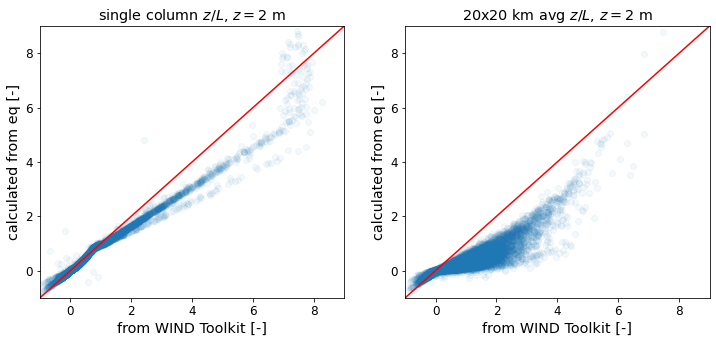

In [40]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set_title(r'single column $z/L$, $z=2$ m', fontsize='x-large')
ax[1].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for i, df in enumerate([dfsc,df20km]):
    ax[i].scatter(df['zoverL_2m'], df['zoverLeq'], alpha=0.05)
    minmax = (-1, 9)
    ax[i].plot(minmax, minmax, 'r')
    ax[i].set_xlim(minmax);  ax[i].set_ylim(minmax)
    ax[i].tick_params(labelsize='large')
    ax[i].set_xlabel(r'from WIND Toolkit [-]', fontsize='x-large')
    ax[i].set_ylabel(r'calculated from eq [-]', fontsize='x-large')
    
# Equation seems to be underestimating for values over z/L > 1 and z/L<8

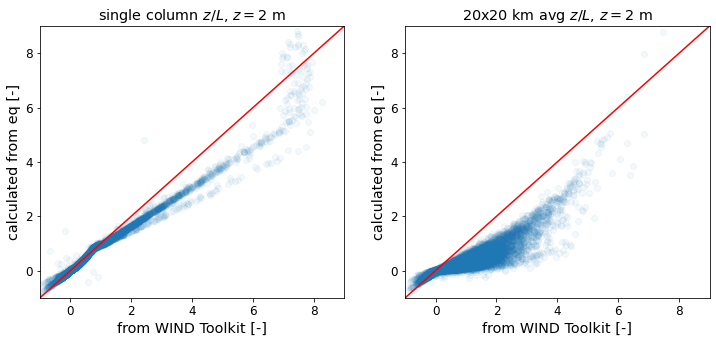

In [41]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set_title(r'single column $z/L$, $z=2$ m', fontsize='x-large')
ax[1].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for i, df in enumerate([dfsc,df20km]):
    ax[i].scatter(df['zoverL_2m'], df['zoverLeq'], alpha=0.05)
    minmax = (-1, 9)
    ax[i].plot(minmax, minmax, 'r')
    ax[i].set_xlim(minmax);  ax[i].set_ylim(minmax)
    ax[i].tick_params(labelsize='large')
    ax[i].set_xlabel(r'from WIND Toolkit [-]', fontsize='x-large')
    ax[i].set_ylabel(r'calculated from eq [-]', fontsize='x-large')
    
# Equation seems to be underestimating for values over z/L > 1 and z/L<8

### 4.6. Classify Stability

Using classification from "On the extension of the wind profile over homogeneous terrain beyond the surface boundary layer" by Gryning et al (BLM 2007).

In [42]:
Lgry = np.array([-50, -100, -200, -500, 500, 200, 50, 10])

# modifying so it's symmetric (following Eliot's early notebook)
Lranges = np.array([-0.5,-50, -200, -500, 500, 200, 50, 0.5])
zoverL_ranges = 2.0 / Lranges
zoverL_range_names = ['VU','U','NU','N','NS','S','VS']

In [43]:
for i, df in enumerate([dfold,dfsc,df20km]):
    zoverL = df['zoverL_2m'].xs(2,level='height')
    inrange = (zoverL >= zoverL_ranges[0]) & (zoverL <= zoverL_ranges[-1])
    Noutliers = np.count_nonzero(~inrange)
    print(f'Dataframe {i}: {Noutliers} outliers out of {len(zoverL)} ({100*Noutliers/len(zoverL)}%)')

Dataframe 0: 0 outliers out of 26304 (0.0%)
Dataframe 1: 379 outliers out of 17520 (2.16324200913242%)
Dataframe 2: 122 outliers out of 17520 (0.6963470319634704%)


In [44]:
# Set stability classification
for df in dfold,dfsc,df20km:
    df['stability'] = pd.cut(df['zoverL_2m'], bins=zoverL_ranges, labels=zoverL_range_names)

### 4.7. Add season/month information

In [45]:
# Add season information
# 0: winter; 1: spring; 2: summer; 3: fall
season_names = ['winter','spring','summer','fall']

dfsc['season']   = ((dfsc.index.levels[0].month%12)//3).repeat(len(heights_u))
df20km['season'] = ((df20km.index.levels[0].month%12)//3).repeat(len(heights_u))
dfold['season']  = ((dfold.index.levels[0].month%12)//3).repeat(len(heights_oldWTK)+1)
dfcasp['season']  = (dfcasp.index.month%12)//3

In [46]:
# Add month information (make it easier to access it later)
month_names = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

dfsc['month']   = (dfsc.index.levels[0].month%12).repeat(len(heights_u))
df20km['month'] = (df20km.index.levels[0].month%12).repeat(len(heights_u))

## - Save DataFrames

In [47]:
dfsc.reset_index().to_feather(os.path.join('data','dfsc.ftr'))
df20km.reset_index().to_feather(os.path.join('data','df20km.ftr'))
dfold.reset_index().to_feather(os.path.join('data','dfold.ftr'))
dfcasp.reset_index().to_feather(os.path.join('data','dfcasp.ftr'))

In [48]:
test = pd.read_feather(os.path.join('data','dfsc.ftr'))

In [49]:
heights_u

array([  0.,   2.,  10.,  20.,  40.,  60.,  80., 100., 120., 140., 160.,
       180., 200.])

In [50]:
df20km.index.levels[1]

Float64Index([  0.0,   2.0,  10.0,  20.0,  40.0,  60.0,  80.0, 100.0, 120.0,
              140.0, 160.0, 180.0, 200.0],
             dtype='float64', name='height')

## 5. Plots

### 5.1. Stability Classification Plots

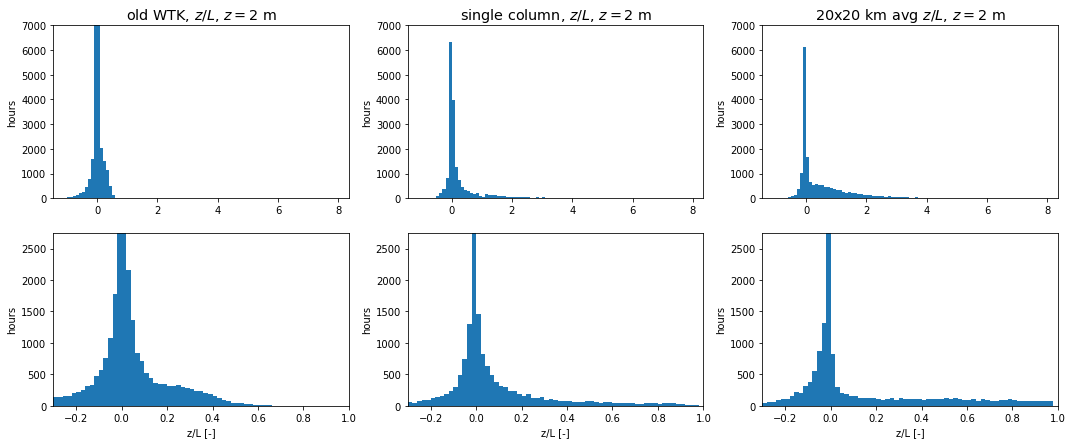

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,7))

ax[0,0].set_title(r'old WTK, $z/L$, $z=2$ m', fontsize='x-large')
ax[0,1].set_title(r'single column, $z/L$, $z=2$ m', fontsize='x-large')
ax[0,2].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for i, df in enumerate([dfold,dfsc,df20km]):
    ax[0,i].hist(df['zoverL_2m'].xs(2,level='height'), bins=np.arange(-1, 8, 0.1))
    ax[0,i].set_ylabel('hours')
    ax[0,i].set_ylim([0,7000])
    
    ax[1,i].hist(df['zoverL_2m'].xs(2,level='height'), bins=np.arange(-0.3, 1, 0.02))
    ax[1,i].set_xlabel('z/L [-]');  ax[1,i].set_ylabel('hours')
    ax[1,i].set_ylim([0,2750]); ax[1,i].set_xlim([-0.3,1])


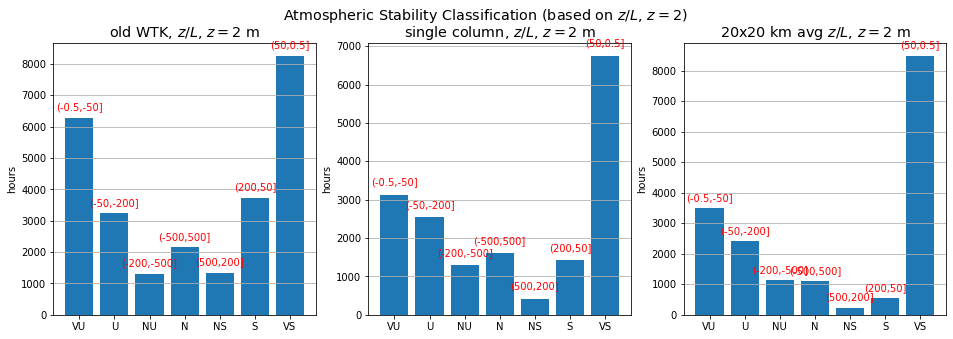

In [52]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

fig.suptitle('Atmospheric Stability Classification (based on $z/L$, $z=2$)',fontsize='x-large')
ax[0].set_title(r'old WTK, $z/L$, $z=2$ m', fontsize='x-large')
ax[1].set_title(r'single column, $z/L$, $z=2$ m', fontsize='x-large')
ax[2].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for d, df in enumerate([dfold,dfsc,df20km]):
    counts = df['stability'].xs(0,level='height').value_counts()[zoverL_range_names]
    ax[d].bar(zoverL_range_names, counts)
    for i, h in enumerate(counts):
        ax[d].text(i,h+250,f'({Lranges[i]:g},{Lranges[i+1]:g}]',fontdict={'color':'r'},horizontalalignment='center')
    #ax[d].text(0.05,0.95,'$L$ bins indicated in red', verticalalignment='top', transform=ax[d].transAxes)
    ax[d].set_ylabel('hours')
    ax[d].grid(axis='y')


### 5.2. Heat flux distribution histograms


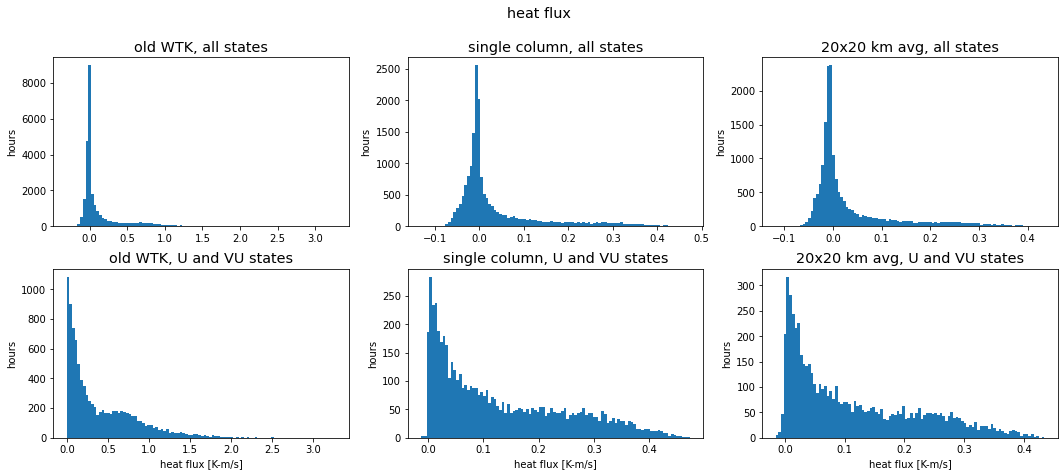

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.subplots_adjust(hspace=0.25)

fig.suptitle('heat flux',fontsize='x-large')
ax[0,0].set_title(r'old WTK, all states', fontsize='x-large')
ax[1,0].set_title(r'old WTK, U and VU states', fontsize='x-large')
ax[0,1].set_title(r'single column, all states', fontsize='x-large')
ax[1,1].set_title(r'single column, U and VU states', fontsize='x-large')
ax[0,2].set_title(r'20x20 km avg, all states', fontsize='x-large')
ax[1,2].set_title(r'20x20 km avg, U and VU states', fontsize='x-large')

for i,df in enumerate([dfold, dfsc,df20km]):
    # heat flux, all states
    heatfluxAll = df['hfx_Kms'].xs(0,level='height')
    # heat flux, U/VS states
    heatfluxU = df['hfx_Kms'].loc[(df['stability']=='U') | (df['stability']=='VU')].xs(0,level='height')

    ax[0,i].hist(heatfluxAll, bins=100)
    ax[0,i].set_ylabel('hours')

    ax[1,i].hist(heatfluxU, bins=100)
    ax[1,i].set_xlabel('heat flux [K-m/s]')
    ax[1,i].set_ylabel('hours')

### 5.3. Seasonal variability

In [54]:
# Aux variables for plotting
dfnames = ['old WTK','single column','20x20 km avg','KCPR airport']

# hours unique
hours_u = np.arange(0,24)

# heights where wind data are available for dfsc and df20km
heights_wind = np.concatenate((np.array([10]),np.arange(20,201,20)))

# hub height for wind roses
zhub = 80

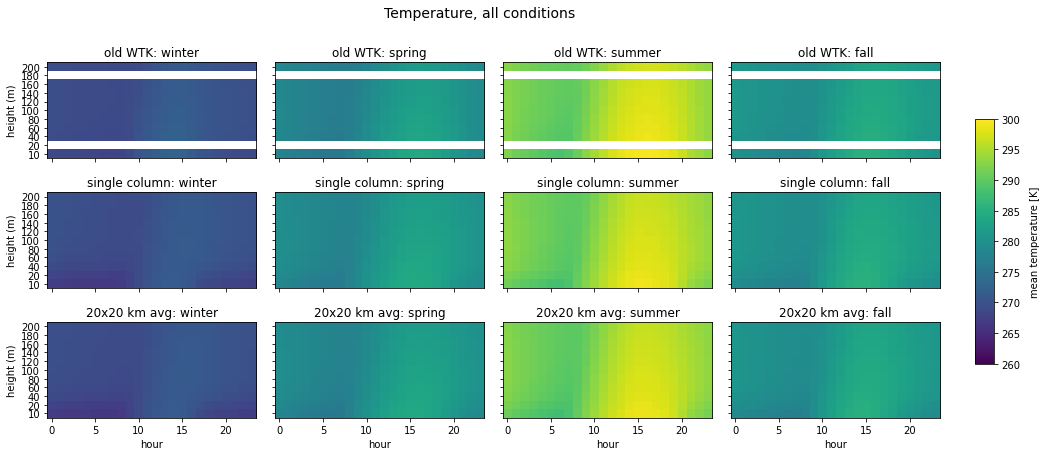

In [55]:
# Temperature over the seasons, at every height for every hour
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(16,6.8))
fig.suptitle('Temperature, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
    
for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
        for (i,z) in enumerate(heights_wind):
            for (j,h) in enumerate(hours_u): 
                try:
                    ws[i,j] = seasonaldata.loc[(s,h,z)]['temperature']    
                except KeyError:
                    ws[i,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=260, vmax=300)
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.017, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean temperature [K]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)')
for axi in ax[1,:]:
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

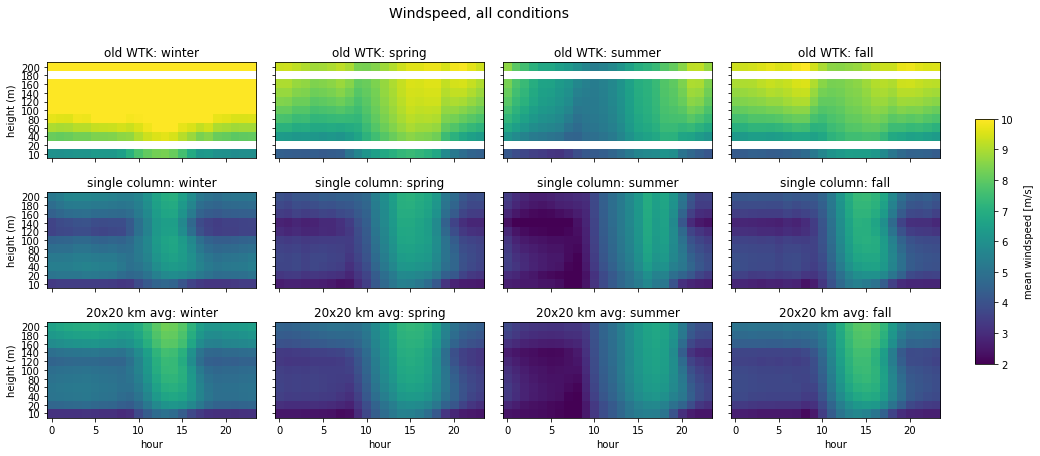

In [56]:
# Wind speed over the seasons, at every height for every hour
fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(16,6.8))
fig.suptitle('Windspeed, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
    
for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
        for (i,z) in enumerate(heights_wind):
            for (j,h) in enumerate(hours_u): 
                try:
                    ws[i,j] = seasonaldata.loc[(s,h,z)]['windspeed']    
                except KeyError:
                    ws[i,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=2, vmax=10)
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.017, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
for axi in ax[:,0]:
    axi.set_ylabel('height (m)')
for axi in ax[1,:]:
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

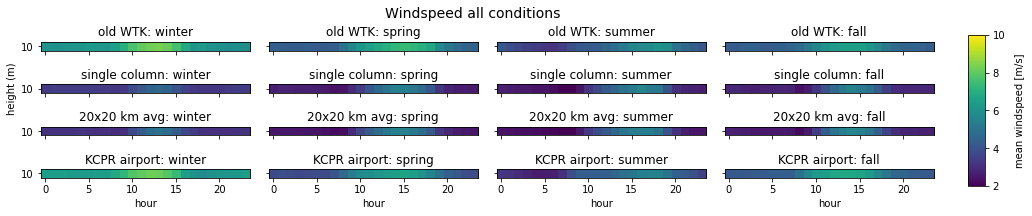

In [57]:
# Wind speed over the seasons, at every height for every hour
zcomp = 10

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(16,3))
fig.suptitle('Windspeed all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)

for d,df in enumerate([dfold,dfsc,df20km]):
    seasonaldata = df.groupby(['season','hour','height']).mean()
    for s in range(4):
        ws = np.zeros(shape=(1,len(hours_u)))
        for (j,h) in enumerate(hours_u): 
            try:
                ws[0,j] = seasonaldata.loc[(s,h,zcomp)]['windspeed']    
            except KeyError:
                ws[0,j] = np.nan
        p = ax[d,s].imshow(ws[:,:], origin='lower',vmin=2, vmax=10)
        ax[d,s].set_title(f'{dfnames[d]}: {season_names[s]}')
        
# airport data (different format)
seasonaldata = dfcasp.groupby(['season','hour']).mean()
for s in range(4):
    ws = np.zeros(shape=(1,len(hours_u)))
    ws[0,:] = seasonaldata.loc[(s,slice(None))]['windspeed']
    ax[3,s].imshow(ws, origin='lower',vmin=2, vmax=10)
    ax[3,s].set_title(f'{dfnames[3]}: {season_names[s]}')

# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.15, 0.015, 0.7]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax[-1,:]:
    axi.set_xlabel('hour')
ax[1,0].set_ylabel('height (m)')
for axi in ax[:,-1]:
    axi.set_yticks([0])
    axi.set_yticklabels([zcomp])

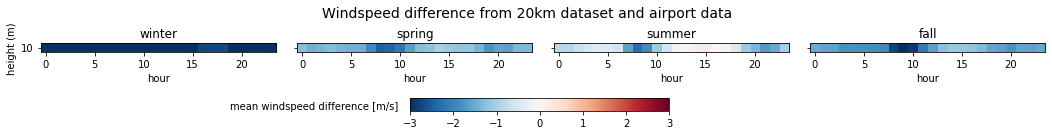

In [58]:
# Deviation of Wind speed from the airport data
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(18,1.2))
fig.suptitle('Windspeed difference from 20km dataset and airport data',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)

seasonaldata20 = df20km.groupby(['season','hour','height']).mean()
seasonaldataWY = dfcasp.groupby(['season','hour']).mean()
for s in range(4):
    ws20 = np.zeros(shape=(1,len(hours_u)))
    wsWY = np.zeros(shape=(1,len(hours_u)))
    
    for (j,h) in enumerate(hours_u): 
        try:
            ws20[0,j] = seasonaldata20.loc[(s,h,zcomp)]['windspeed']    
        except KeyError:
            ws20[0,j] = np.nan
    wsWY[0,:] = seasonaldataWY.loc[(s,slice(None))]['windspeed']        

    p = ax[s].imshow(ws20-wsWY, origin='lower',vmin=-3, vmax=3, cmap='RdBu_r')
    
    ax[s].set_title(f'{season_names[s]}')

# set titles, labels and colorbar
cb_ax = fig.add_axes([0.41,-0.23,0.2, 0.15]);  cbar = fig.colorbar(p, cax = cb_ax, orientation='horizontal')
cb_ax.set_ylabel('mean windspeed difference [m/s]',labelpad=180, rotation=0, loc='bottom')
for axi in ax:
    axi.set_xlabel('hour')
ax[0].set_ylabel('height (m)')
for axi in ax[:]:
    axi.set_yticks([0])
    axi.set_yticklabels([zcomp])


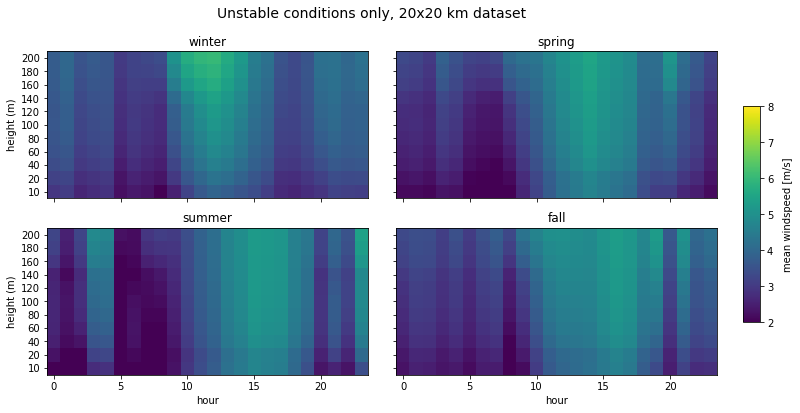

In [59]:
# Unstable only

fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.suptitle('Unstable conditions only, 20x20 km dataset',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
ax=ax1.flatten()

for s in range(4):
    seasonaldataU = df20km.loc[(df20km['stability']=='U') | (df20km['stability']=='VU')].groupby(['season','hour','height']).mean()
    ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
    for (i,z) in enumerate(heights_wind):
        for (j,h) in enumerate(hours_u): 
            ws[i,j] = seasonaldataU.loc[(s,h,z)]['windspeed']       
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=2, vmax=8)
    ax[s].set_title(f'{season_names[s]}')
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

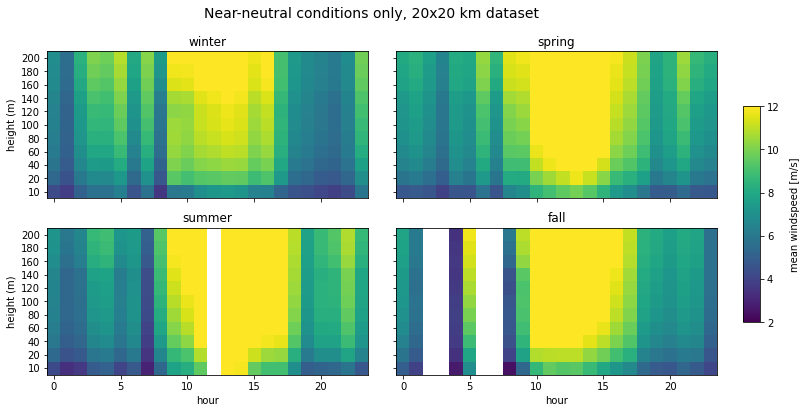

In [60]:
# only near-neutral
# missing data is because there is no conditions that match

fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,6))
fig.suptitle('Near-neutral conditions only, 20x20 km dataset',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
ax=ax1.flatten()

for s in range(4):
    seasonaldataN = df20km.loc[df20km['stability']=='N'].groupby(['season','hour','height']).mean()
    ws = np.zeros(shape=(len(heights_wind),len(hours_u)))
    for (i,z) in enumerate(heights_wind):
        for (j,h) in enumerate(hours_u): 
            try:
                ws[i,j] = seasonaldataN.loc[(s,h,z)]['windspeed']    
            except KeyError:
                ws[i,j] = np.nan
                    
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=2, vmax=12)
    ax[s].set_title(f'{season_names[s]}')
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('mean windspeed [m/s]',labelpad=10)
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.linspace(0,10,11))
    axi.set_yticklabels(heights_wind)

### 5.4. Daytime and nighttime wind roses
`windrose` convention for wind direction: northerly winds (from N to S) is 0 degrees, increase clockwise


In [61]:
# Auxiliary windrose plots variables
rec2x2 = [[0,0.5,0.4,0.4],[0.5,0.5,0.4,0.4],[0,0,0.4,0.4],[0.5,0,0.4,0.4]]
rec4x1 = [[0.00,0.00,0.22,1],[0.25,0.00,0.22,1],[0.50,0.00,0.22,1],[0.75,0.00,0.22,1]]
rec4x2 = [[0.00,0.50,0.22,0.45],[0.25,0.50,0.22,0.45],[0.50,0.50,0.22,0.45],[0.75,0.50,0.22,0.45],\
          [0.00,0.00,0.22,0.45],[0.25,0.00,0.22,0.45],[0.50,0.00,0.22,0.45],[0.75,0.00,0.22,0.45]]
rec4x4 = [[0.00,0.75,0.22,0.22],[0.25,0.75,0.22,0.22],[0.50,0.75,0.22,0.22],[0.75,0.75,0.22,0.22],\
          [0.00,0.50,0.22,0.22],[0.25,0.50,0.22,0.22],[0.50,0.50,0.22,0.22],[0.75,0.50,0.22,0.22],\
          [0.00,0.25,0.22,0.22],[0.25,0.25,0.22,0.22],[0.50,0.25,0.22,0.22],[0.75,0.25,0.22,0.22],\
          [0.00,0.00,0.22,0.22],[0.25,0.00,0.22,0.22],[0.50,0.00,0.22,0.22],[0.75,0.00,0.22,0.22]]

bins=([0,2,4,6,8,10,12,14])

wrlabels = ['','NE','','NW','','SW','','SE']

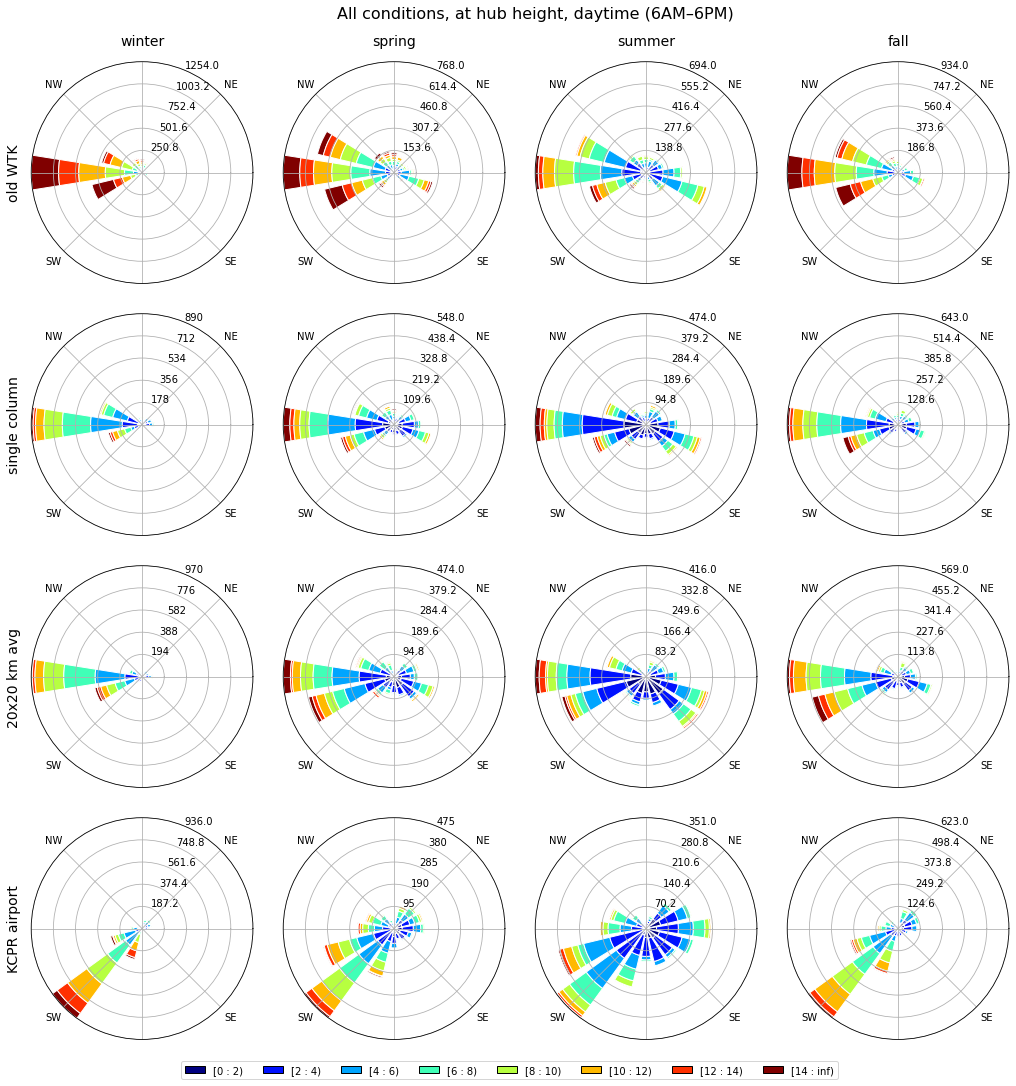

In [62]:
# Daytime, all conditions
fig = plt.figure(figsize=(14,14))
fig.suptitle('All conditions, at hub height, daytime (6AM–6PM)', y=1.025, fontsize=16)

for d,df in enumerate([dfold,dfsc,df20km,dfcasp]):
    for s in range(4):
        wa = wr.WindroseAxes(fig, rec4x4[d*4+s])
        fig.add_axes(wa)
        if d==3: data = dfcasp.loc[(dfcasp['season']==s) & (dfcasp['hour']>=6) & (dfcasp['hour']<18)]
        else:    data = df.loc[(df['season']==s) & (df['hour']>=6) & (df['hour']<18)].xs(zhub, level='height') 
        ws = data['windspeed'].values
        wd = data['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
        wa.set_xticklabels(wrlabels)
        if d==0: wa.set_title(f'{season_names[s]}',fontsize=14, y=1.05)
        if s==0: wa.set_ylabel(f'{dfnames[d]}', fontsize=14, labelpad=10)

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))

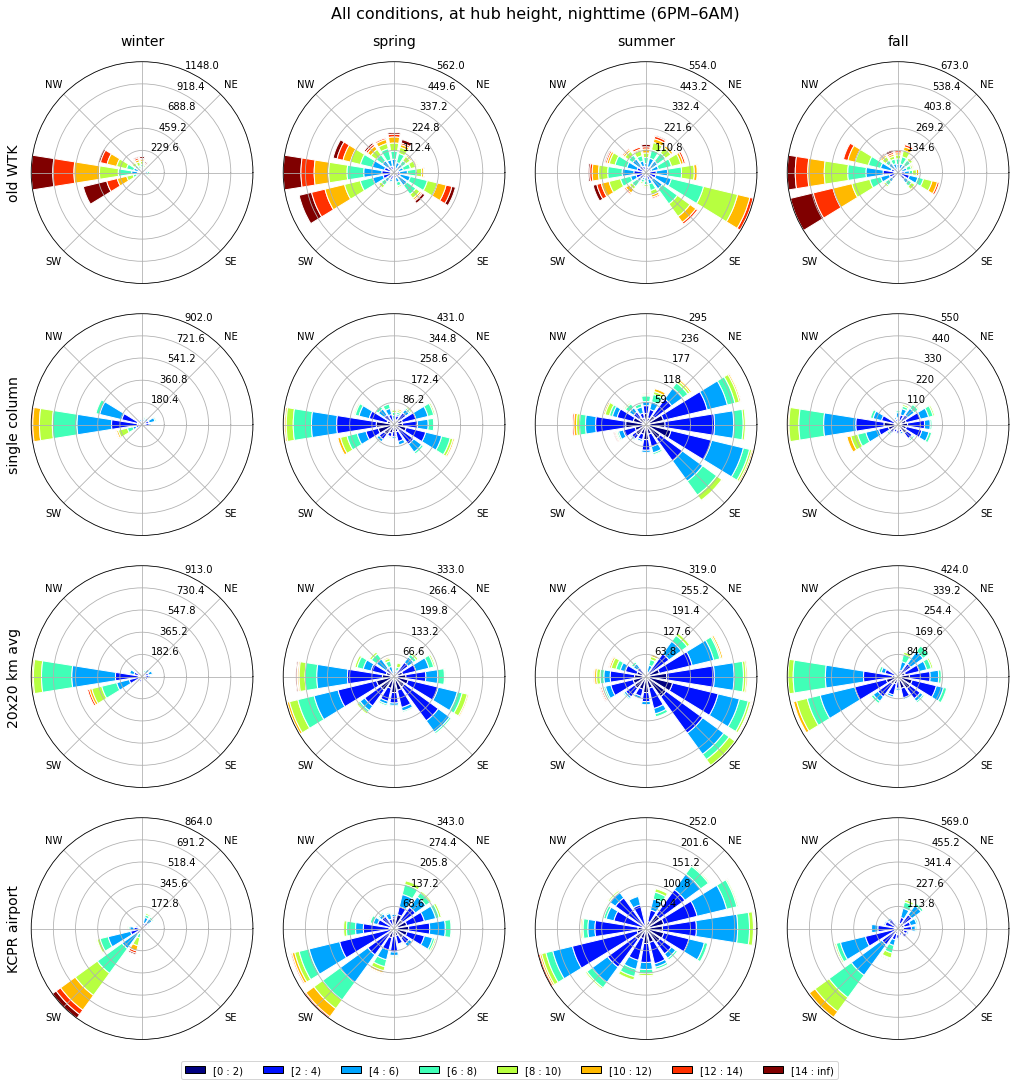

In [63]:
# Nighttime, all conditions
fig = plt.figure(figsize=(14,14))
fig.suptitle('All conditions, at hub height, nighttime (6PM–6AM)', y=1.025, fontsize=16)

for d,df in enumerate([dfold,dfsc,df20km,dfcasp]):
    for s in range(4):
        wa = wr.WindroseAxes(fig, rec4x4[d*4+s])
        fig.add_axes(wa)
        if d==3: data = dfcasp.loc[(dfcasp['season']==s) & ((dfcasp['hour']<6) | (dfcasp['hour']>=18))]
        else:    data = df.loc[(df['season']==s) & ((df['hour']<6) | (df['hour']>=18))].xs(zhub, level='height')  
        ws = data['windspeed'].values
        wd = data['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
        wa.set_xticklabels(wrlabels)
        if d==0: wa.set_title(f'{season_names[s]}',fontsize=14, y=1.05)
        if s==0: wa.set_ylabel(f'{dfnames[d]}', fontsize=14, labelpad=10)

wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))

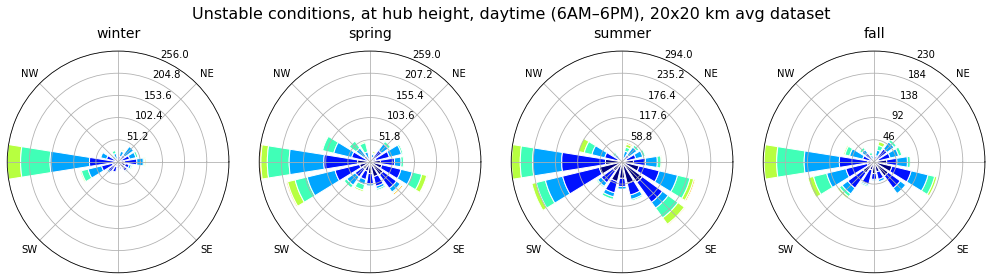

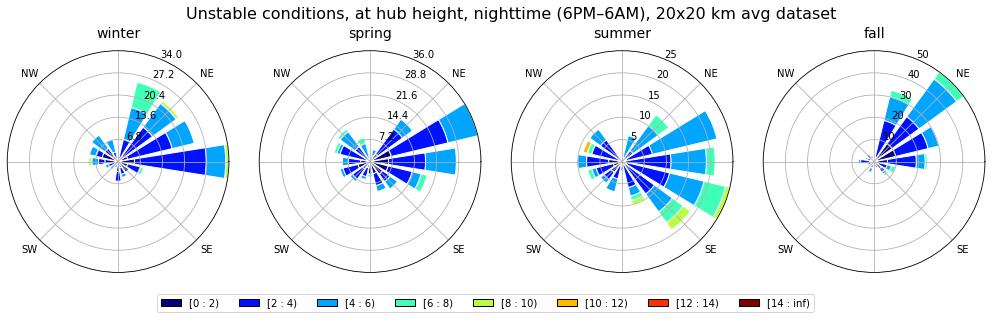

In [64]:
# Unstable conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)

df=df20km

for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
plt.show()
print('\n\n')

fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, at hub height, nighttime (6PM–6AM), 20x20 km avg dataset', y=0.93, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & ((df['hour']<6)|(df['hour']>=18)) & ((df['stability']=='U')|(df['stability']=='VU')))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
    
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()

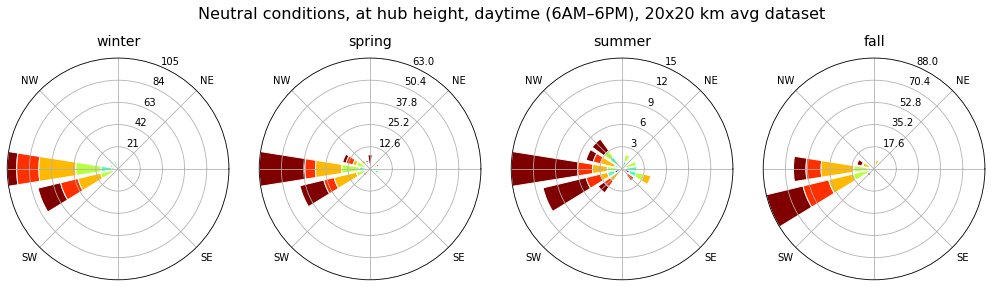

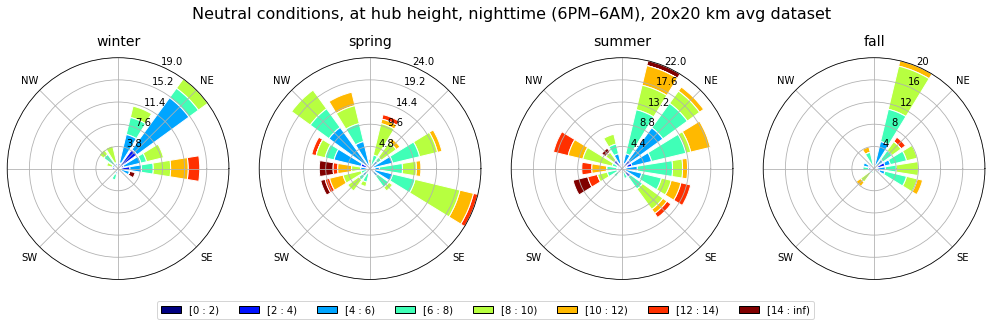

In [65]:
# Neutral conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Neutral conditions, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.95, fontsize=16)

df=df20km

for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & (df['stability']=='N'))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
plt.show()
print('\n\n')

fig = plt.figure(figsize=(14,5))
fig.suptitle('Neutral conditions, at hub height, nighttime (6PM–6AM), 20x20 km avg dataset', y=0.95, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & ((df['hour']<6)|(df['hour']>=18)) & (df['stability']=='N'))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
    
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()

### 5.5. Heat flux on selected scenarios

In [66]:
# Copy wind direction info from zhub to 0m so it's easier to slice/loc dataframe with hfx information
df20km.loc[(slice(None),0),'dir'] = df20km.xs(zhub, level='height')['dir'].values

Text(0.5, 1.0, 'heat flux: W winds, U/VU states, Daytime, 20x20 km dataset')

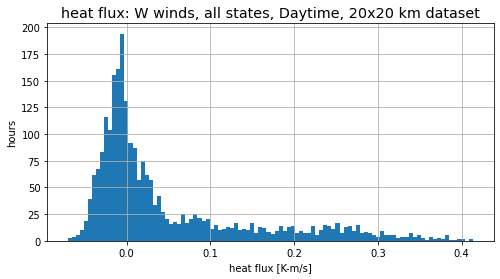

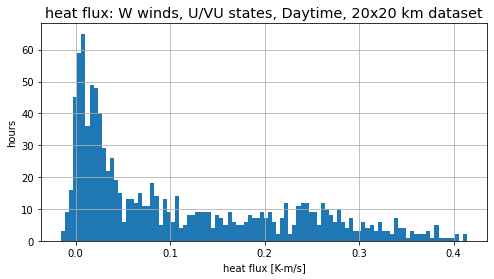

In [67]:
# heat flux, all states, W winds only
cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18))
heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=100)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: W winds, all states, Daytime, 20x20 km dataset', fontsize='x-large')

# heat flux, U/VU states
cond = (df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU'))
heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
#heatflux = df['hfx_kms'].loc[(df['stability']=='U') | (df['stability']=='VU')].xs(0,level='height')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=100)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: W winds, U/VU states, Daytime, 20x20 km dataset', fontsize='x-large')

## 6. Thermal updrafts
Attempting to classify by thermal updrafts. The convective velocity for CBLs $w_*$ is given by
\begin{equation}
w_* = \left( \frac{g z_i \overline{(\theta'w')}_s}{\bar{\theta}} \right)^{1/3} 
\end{equation}

Greenhut and Khalsa (J. Clim. Appl. Meteorol., 1982) defined thermal updrafts and downdrafts as those parts of the data series that exceed a specific velocity threshold. Thermal updrafts are defined as that part of the data series in which the vertical velocity exceeds $0.56w_∗$, and thermal downdrafts are defined as that part of the data series in which the vertical velocity is less than $−0.40w_∗$. We do not have the vertical velocity of the velocity from the WTK though.


In [68]:
for df in df20km,dfsc:
    zi = df['z_i'].xs(0,level='height').values
    Tw = df['hfx_Kms'].xs(0,level='height').values
    Temp = df['thetav'].xs(2,level='height').values
    df['wstar'] = ((g*zi*Tw/Temp)**(1/3)).repeat(len(heights_u))

<ipython-input-68-abaf78a9a9be>:5: RuntimeWarning: invalid value encountered in power
  df['wstar'] = ((g*zi*Tw/Temp)**(1/3)).repeat(len(heights_u))


### 6.1. Estimate the mean vertical velocity in thermal updrafts
From Shannon et al, BLM 104 (2002): 167--199, "Measurements of Thermal Updraft Intensity Over Complex Terrain Using American White Pelicans and a Simple Boundary-Layer Forecast Model":

"For example, in examining a time series of vertical velocity data obtained from aircraft measurements, Young (1988) defined those parts of the data series with positive vertical velocities as thermal updrafts, while the remainder of the data series was classified as environmental downdraft. Young showed that the mean vertical velocity in thermal updrafts $\overline{w_T}}$ at some altitude $z$ can be approximated through the relationship,
\begin{equation}
\frac{\overline{w_T}}{w_*} = 0.85 \left( \frac{z}{z_i} \right)^{1/3} \left( 1.3 - \frac{z}{z_i} \right)
\end{equation}
where $z_i$ is the boundary-layer depth and $w_∗$ is the convective velocity scale"


In [69]:
for df in dfsc, df20km:
    zi = df['z_i'].xs(0,level='height').repeat(len(heights_u)).values
    z = df.reset_index()['height'].values
    #z = heights_u.repeat(len(heights_u))
    df['wT'] = df['wstar']*0.85*(z/zi)**(1/3)*(1.3-z/zi)

In [70]:
df20km['wT'].describe()

count    102284.000000
mean          0.472450
std           0.329076
min          -1.469659
25%           0.223055
50%           0.420717
75%           0.691391
max           1.461557
Name: wT, dtype: float64

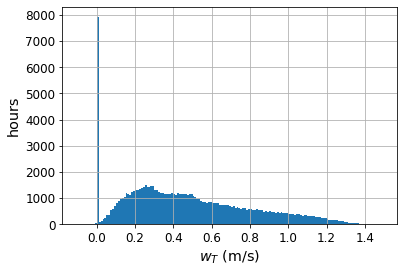

In [71]:
ax = df20km['wT'].hist(bins=np.arange(-0.1,1.5,0.01))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_T$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()

count    992.000000
mean       0.587458
std        0.281534
min       -0.111346
25%        0.343732
50%        0.558070
75%        0.860780
max        1.108768
Name: wT, dtype: float64


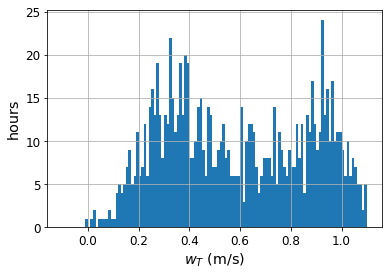

In [72]:
# Unstable, daytime, W winds
cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU')))
updraft = df20km.loc[cond]['wT'].xs(zhub,level='height')
print(updraft.describe())

ax = updraft.hist(bins=np.arange(-0.1,1.1,0.01))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_T$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()

### 6.2. Wind roses with data exceding updraft threshold
Now, let's go back to the wind roses and use only data related to those scenarios where the threshold of 0.85 m/s has been exceeded

In [73]:
aboveThreshold = df20km.loc[df20km['wT']>=0.85]

array([[<AxesSubplot:title={'center':'inverseL_2m'}>,
        <AxesSubplot:title={'center':'pressure'}>,
        <AxesSubplot:title={'center':'RH_2m'}>,
        <AxesSubplot:title={'center':'temperature'}>],
       [<AxesSubplot:title={'center':'tke'}>,
        <AxesSubplot:title={'center':'winddirection'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'thetav'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'zoverL_2m'}>],
       [<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'wstar'}>,
        <AxesSubplot:title={'center':'wT'}>, <AxesSubplot:>]],
      dtype=object)

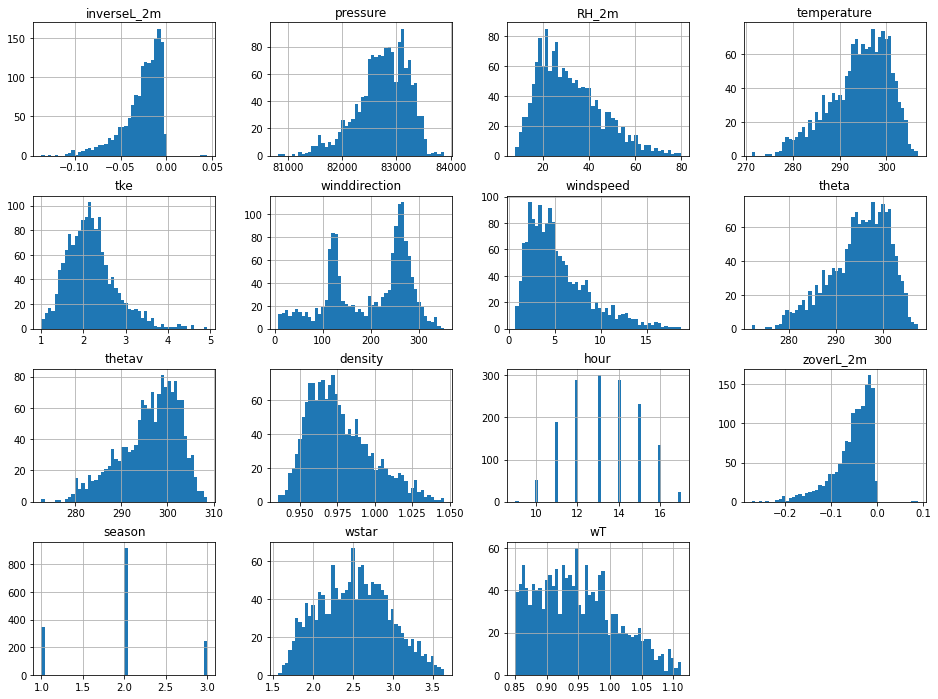

In [74]:
aboveThreshold.xs(zhub,level='height').hist([ 'inverseL_2m',
                     'pressure','RH_2m', 
                     'temperature', 'tke','winddirection', 'windspeed', 'theta',
                     'thetav', 'density', 'dir', 'hour',
                     'zoverL_2m',  'stability','season', 'wstar', 'wT'],figsize=(16,12),bins=50)

<AxesSubplot:>

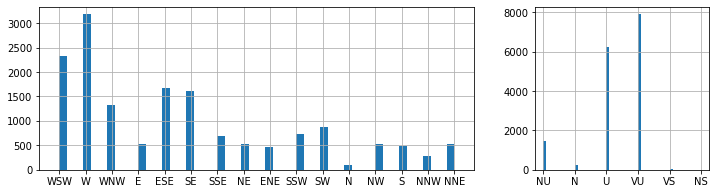

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3), gridspec_kw={'width_ratios': [2.5, 1]})

aboveThreshold['dir'].hist(bins=50,ax=axs[0])
aboveThreshold['stability'].hist(bins=50, ax=axs[1])

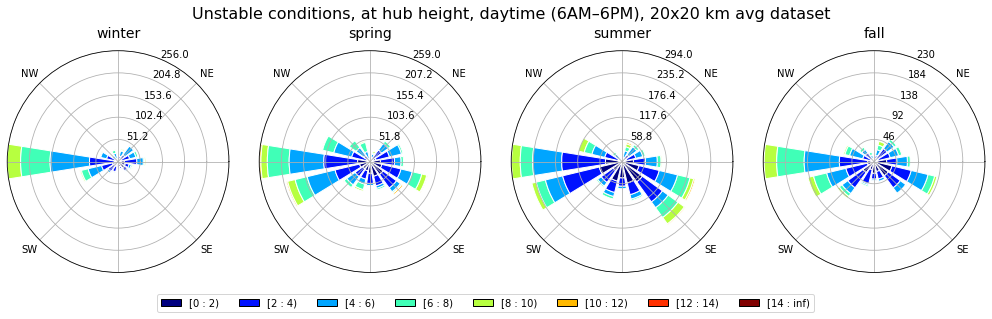

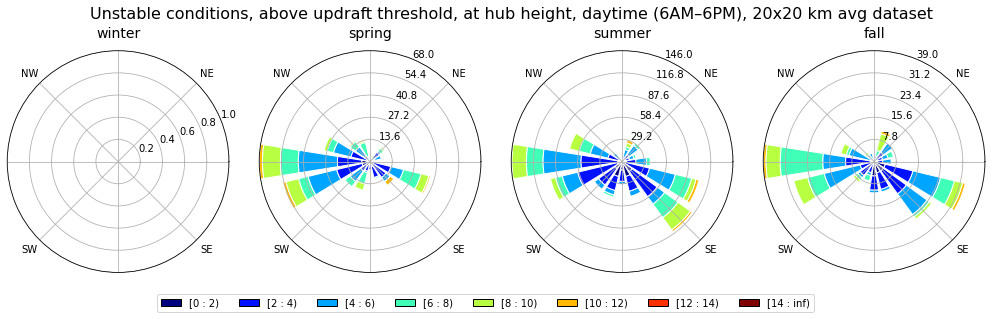

In [76]:
df=df20km

# Unstable, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')))# & (df['wT']>=0.85))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')


fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, above updraft threshold, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    try:
        fig.add_axes(wa)
        cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')) & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()

### 6.3. Back at heat flux when updrafts are above the threshold

Text(0.5, 1.0, 'heat flux: above threshold, W winds, U/VU states, Daytime, 20x20 km dataset')

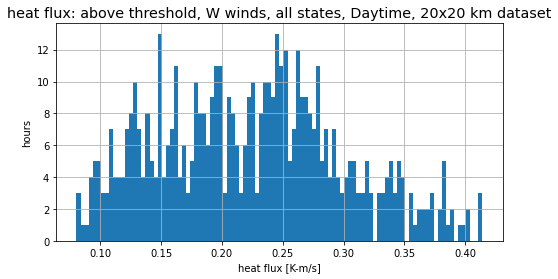

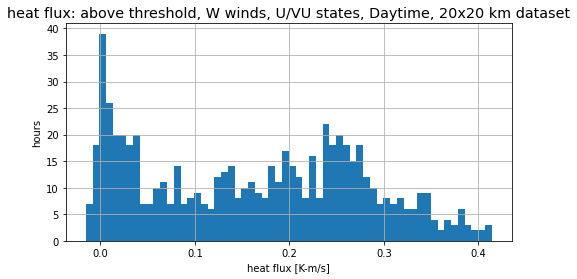

In [77]:
# heat flux, above threshold, all states, W winds only
cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['wT']>=0.85))
positions = df20km.loc[cond]
heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=100)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: above threshold, W winds, all states, Daytime, 20x20 km dataset', fontsize='x-large')

# heat flux, above threshold, U/VS states, W winds
cond = (df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU') & (df20km['wT']>=0.85))
positions = df20km.loc[cond]
heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=60)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: above threshold, W winds, U/VU states, Daytime, 20x20 km dataset', fontsize='x-large')

### 6.4. Spring variation

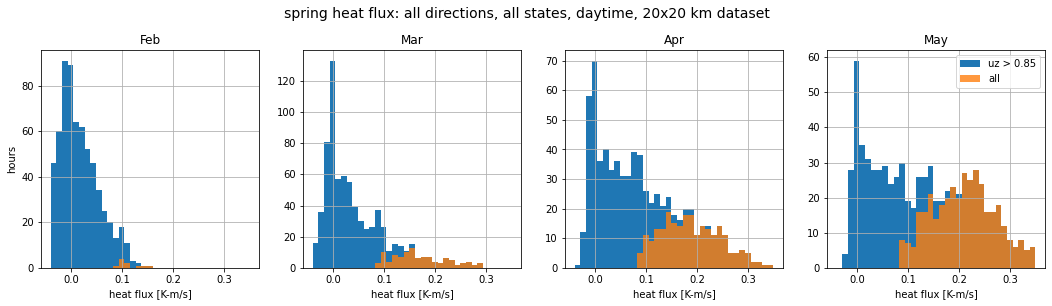

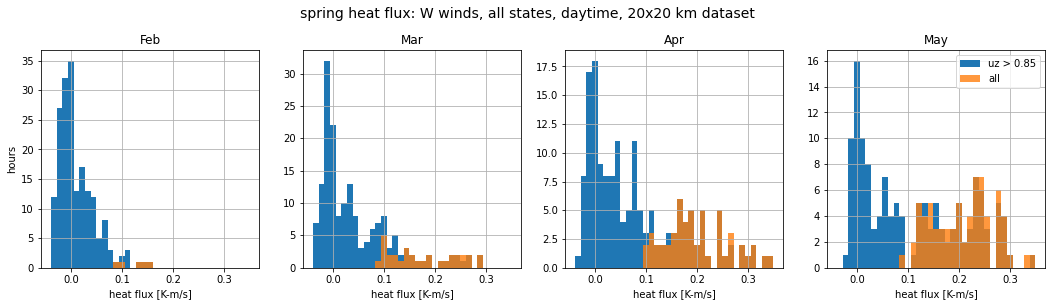

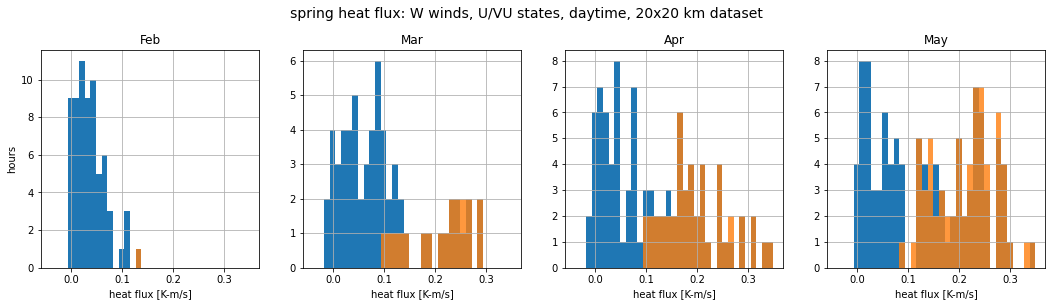

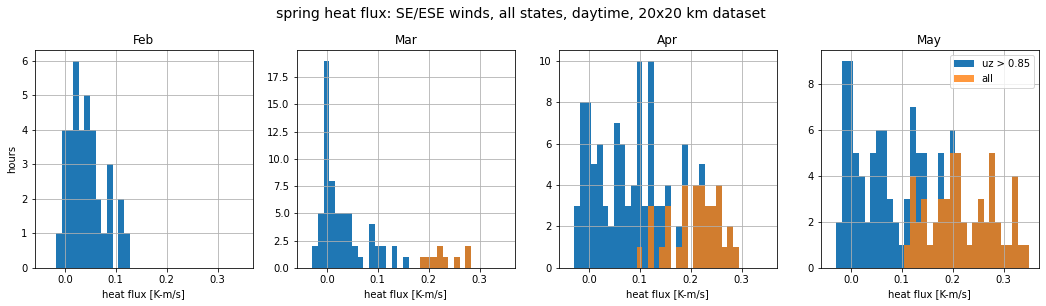

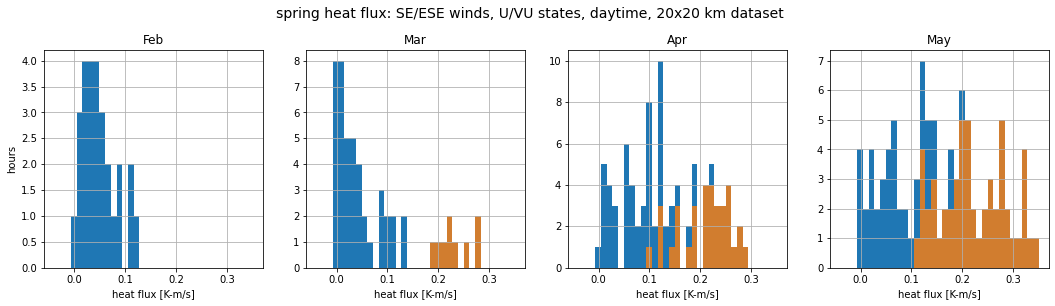

In [78]:
nBins=35
alpha=0.8
histrange=[-0.04, 0.35]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: all directions, all states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, all states, daytime
    cond = ((df20km['hour']>=6) & (df20km['hour']<18) & (df20km['month']==m))
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
axs[3].legend({'all','uz > 0.85'})
plt.show()
print('\n')

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: W winds, all states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, all states, daytime
    cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['month']==m))
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
axs[3].legend({'all','uz > 0.85'})
plt.show()
print('\n')


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: W winds, U/VU states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, U/VU states, daytime
    cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU'))  & (df20km['month']==m) )
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: SE/ESE winds, all states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, all states, daytime
    cond = ( ((df20km['dir']=='SE')|(df20km['dir']=='ESE')) & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['month']==m))
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
axs[3].legend({'all','uz > 0.85'})
plt.show()
print('\n')


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: SE/ESE winds, U/VU states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, U/VU states, daytime
    cond = ( ((df20km['dir']=='SE')|(df20km['dir']=='ESE')) & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU'))  & (df20km['month']==m) )
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
plt.show()

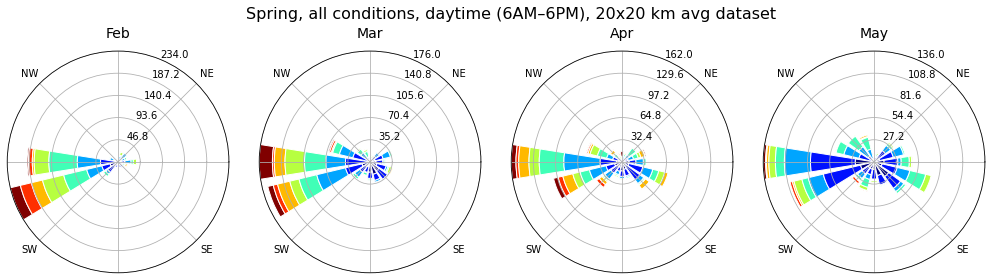

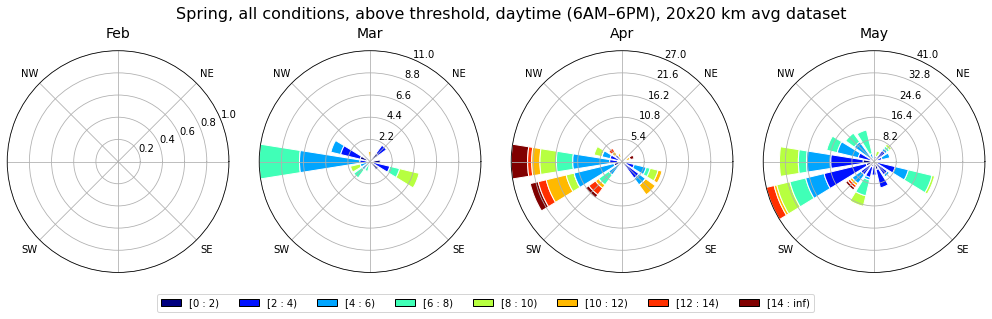

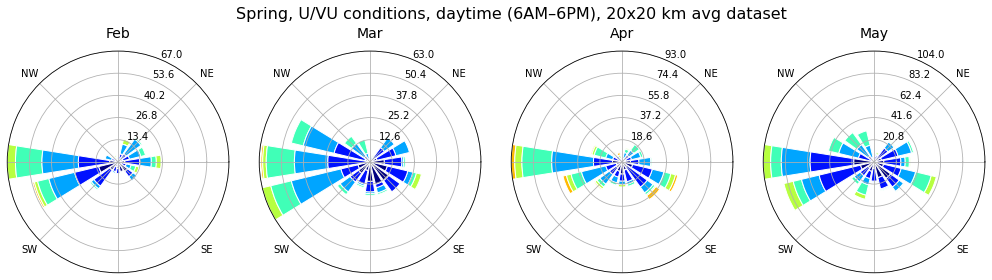

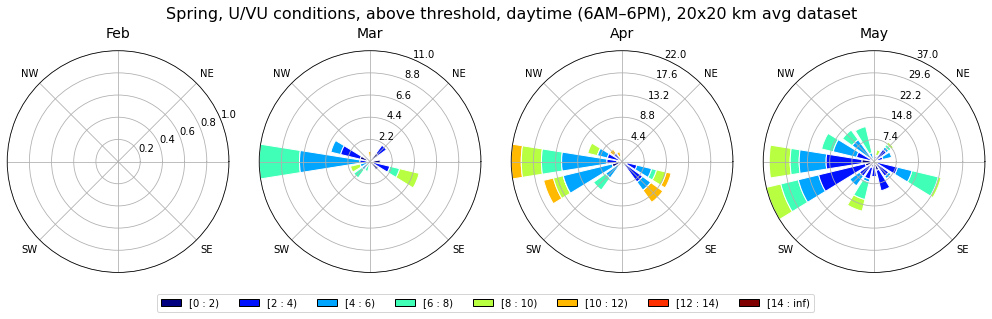

In [79]:
df=df20km

# all conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, all conditions, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    fig.add_axes(wa)
    try:
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) )# & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
plt.show()
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, all conditions, above threshold, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    try:
        fig.add_axes(wa)
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')


# unstable conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, U/VU conditions, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    try:
        fig.add_axes(wa)
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')))# & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
plt.show()
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, U/VU conditions, above threshold, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    fig.add_axes(wa)
    try:  
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')) & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values 
        wa.bar(wd, ws,bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')

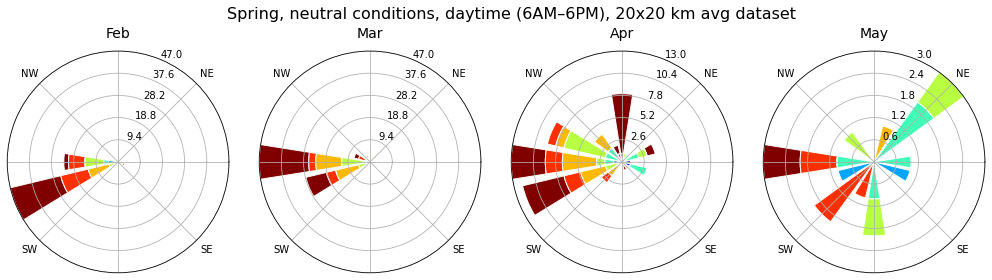

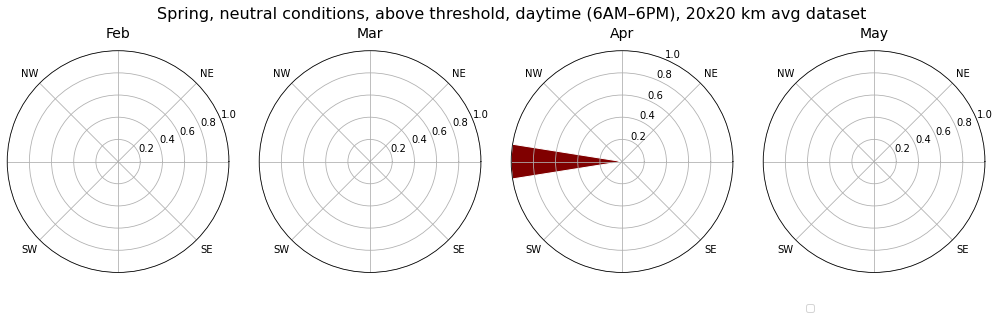

In [80]:
# neutral conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, neutral conditions, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    try:
        fig.add_axes(wa)
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & (df['stability']=='N'))# & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
plt.show()
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, neutral conditions, above threshold, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    fig.add_axes(wa)
    try: 
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & (df['stability']=='N') & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values 
        wa.bar(wd, ws,bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')

[Text(0, 0, '0')]

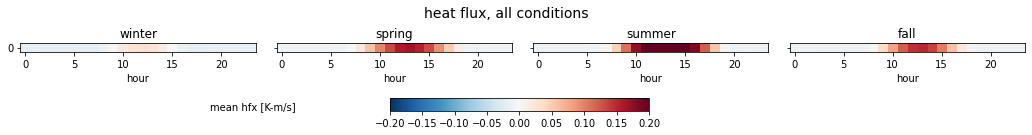

In [81]:
# Wind speed over the seasons, at every height for every hour
zcomp = 0

fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(18,1.2))
fig.suptitle('heat flux, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)


seasonaldata = df20km.groupby(['season','hour','height']).mean()
for s in range(4):
    ws = np.zeros(shape=(1,len(hours_u)))
    for (j,h) in enumerate(hours_u): 
        try:
            ws[0,j] = seasonaldata.loc[(s,h,zcomp)]['hfx_Kms']    
        except KeyError:
            ws[0,j] = np.nan
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    ax[s].set_title(f'{season_names[s]}')

# set titles, labels and colorbar
cb_ax = fig.add_axes([0.41,-0.23,0.2, 0.15]);  cbar = fig.colorbar(p, cax = cb_ax, orientation='horizontal') 
cb_ax.set_ylabel('mean hfx [K-m/s]',labelpad=180, rotation=0, loc='bottom')


for axi in ax:
    axi.set_xlabel('hour')

ax[0].set_yticks([0])
ax[0].set_yticklabels([zcomp])

## 7. Cases to run

Given the plots above, we select a few canonical conditions to run


### 7.1. Estimate the surface roughness
Using the simple expression 

\begin{equation}
u = \frac{u_*}{\kappa} \ln \left( \frac{z}{z_0} \right)
\end{equation}

that really only applies to unobstructed neutral conditions. We will only check neutral conditions.

In [82]:
z = df20km.index.get_level_values(level='height')
ustar = df20km['ustar'].xs(0,level='height').repeat(len(heights_u)).values
df20km['z0'] = z* np.exp(-df20km['windspeed']*k/ustar)

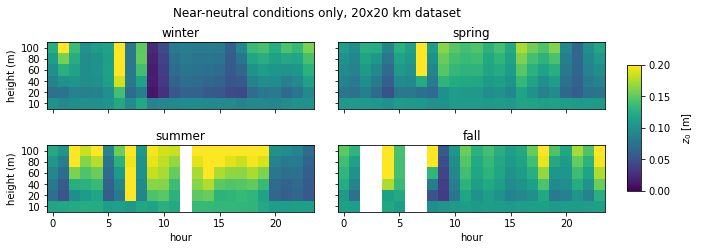

In [79]:
fig, ax1 = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,3.5))
fig.suptitle('Near-neutral conditions only, 20x20 km dataset',fontsize=12)
fig.subplots_adjust(hspace=0.18, wspace=0.09)
ax=ax1.flatten()
heights_z0 = heights_wind[:6]

for s in range(4):
    seasonaldataN = df20km.loc[df20km['stability']=='N'].groupby(['season','hour','height']).mean()
    ws = np.zeros(shape=(len(heights_z0),len(hours_u)))
    for (i,z) in enumerate(heights_z0):
        for (j,h) in enumerate(hours_u): 
            try:
                ws[i,j] = seasonaldataN.loc[(s,h,z)]['z0']    
            except KeyError:
                ws[i,j] = np.nan
                    
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=0, vmax=0.2)
    ax[s].set_title(f'{season_names[s]}')
    
# set titles, labels and colorbar
cb_ax = fig.add_axes([0.93,0.25, 0.02, 0.5]);  cbar = fig.colorbar(p, cax = cb_ax) 
cb_ax.set_ylabel('$z_0$ [m]',labelpad=10)
for axi in ax1[-1,:]:
    axi.set_xlabel('hour')
for axi in ax1[:,0]:
    axi.set_ylabel('height (m)')
    axi.set_yticks(np.arange(len(heights_z0)))
    axi.set_yticklabels(heights_z0)

We will use the surface roughness obtained using $u(80m)$, during daytime over the spring

In [80]:
cond = (df20km['stability']=='N') & (df20km['season']==1) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_sp = df20km.loc[cond].xs(80,level='height')['z0'].mean()

In [81]:
cond = (df20km['stability']=='N') & (df20km['season']==0) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_wi = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df20km['season']==1) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_sp = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df20km['season']==2) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_su = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df20km['season']==3) & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_fa = df20km.loc[cond].xs(80,level='height')['z0'].mean()

cond = (df20km['stability']=='N') & (df['hour']>=6) & (df['hour']<18)
z0_z80_neutral_all = df20km.loc[cond].xs(80,level='height')['z0'].mean()

In [82]:
print(f'The average surface roughness during the day under neutral conditions is:')
print(f'Winter: {z0_z80_neutral_wi:.4f} m\nSpring: {z0_z80_neutral_sp:.4f} m')
print(f'Summer: {z0_z80_neutral_su:.4f} m\nFall: {z0_z80_neutral_fa:.4f} m')
print(f'All year: {z0_z80_neutral_all:.4f} m')

The average surface roughness during the day under neutral conditions is:
Winter: 0.0808 m
Spring: 0.1713 m
Summer: 0.1821 m
Fall: 0.1222 m
All year: 0.1260 m


### 7.2. Boundary layer height

In [83]:
df20km['z_i']

datetime                   height
2016-12-31 17:00:00-07:00  0.0       240.61145
                           2.0             NaN
                           10.0            NaN
                           20.0            NaN
                           40.0            NaN
                                       ...    
2018-12-31 16:00:00-07:00  120.0           NaN
                           140.0           NaN
                           160.0           NaN
                           180.0           NaN
                           200.0           NaN
Name: z_i, Length: 227760, dtype: float64

In [84]:
datefrom=df20km.index.levels[0][0]
dateto=df20km.index.levels[0][10000]

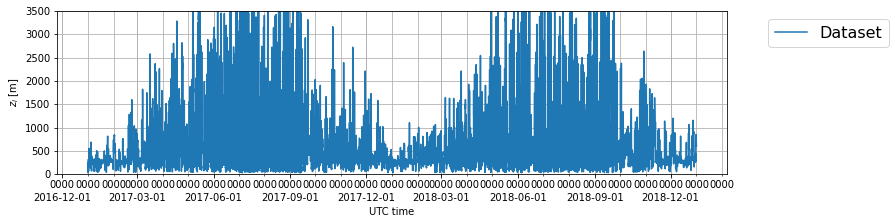

In [85]:
fig, ax = plot_timehistory_at_height(
    df20km,
    fields=['z_i'],
    heights=0,
    #timelimits=[datefrom, dateto],
    fieldlabels={'z_i':r'$z_i$ [m]'},
    fieldlimits={'z_i':[0,3500]},
    showlegend=True,
    #plot_local_time=True,
    #local_time_offset=-7,
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

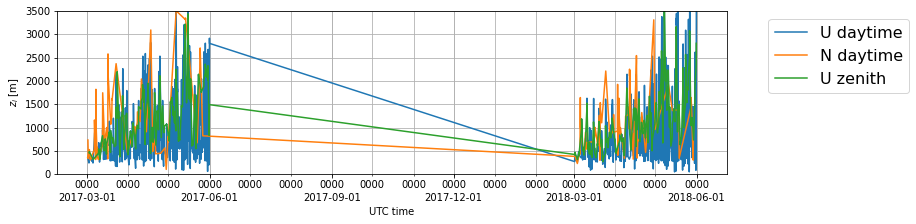

In [86]:
fig, ax = plot_timehistory_at_height(
    datasets={
              'U daytime':df20km.loc[((df['stability']=='U')|(df['stability']=='VU')) & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['season']==1)], \
             #'U nighttime':df20km.loc[((df['stability']=='U')|(df['stability']=='VU')) &  ((df['hour']<6)|(df['hour']>=18)) & (df20km['season']==1)], \
              'N daytime':df20km.loc[(df20km['stability']=='N') & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['season']==1)], \
             #'N nighttime':df20km.loc[(df20km['stability']=='N') & ((df['hour']<6)|(df['hour']>=18)) & (df20km['season']=1)], \
              'U zenith':df20km.loc[((df['stability']=='U')|(df['stability']=='VU')) & (df20km['hour']>=12) & (df20km['hour']<14) & (df20km['season']==1)], \
             #'N zenith':df20km.loc[(df20km['stability']=='N') & (df20km['hour']>=12) & (df20km['hour']<14) & (df20km['season']==1)], \
             },
    fields=['z_i'],
    heights=0,
    #timelimits=[datefrom, dateto],
    fieldlabels={'z_i':r'$z_i$ [m]'},
    fieldlimits={'z_i':[0,3500]},
    showlegend=True,
    #plot_local_time=True,
    #local_time_offset=-7,
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

### 7.3. Summary of cases


Neutral cases:

| Scenario               | Wind dir      | Wind speed | $z_0$  | $\Delta T$ inv .| heat flux  | $z_i$  |
|-----------------------:|:-------------:|:----------:|:------:|:---------------:|:----------:|:------:|
| early spring neutral   | WSW 247.5 deg | 10 m/s     | 0.17 m | 8 K             |  0 K-m/s   |  750 m |
| late spring neutral    | WSW 247.5 deg | 12 m/s     | 0.17 m | 8 K             |  0 K-m/s   |  750 m |

Convective cases:

| Scenario               | Wind dir      | Wind speed | $z_0$  | $\Delta T$ inv | heat flux  | $z_i$  |
|-----------------------:|:-------------:|:----------:|:------:|:--------------:|:----------:|:------:|
| early spring unstable  | WSW 247.5 deg | 6 m/s      | 0.17 m | 10 K           | 0.12 K-m/s | 1.5 km |
| late spring unstable   | WSW 247.5 deg | 8 m/s      | 0.17 m | 10 K           | 0.20 K-m/s | 2 km |
| late spring unstable   | ESE 112.5deg  | 6 m/s      | 0.17 m | 10 K           | 0.12 K-m/s | 2 km |
| late spring unstable   | ESE 112.5deg  | 6 m/s      | 0.17 m | 10 K           | 0.20 K-m/s | 2 km |

In Chris Farmer's presentation, he has some wind direction associated with fatalities. It is also mentioned that "high-risk flights peaked between 190 and 220 degrees". Trying to use some of his cases to compare, these are the additional scenarios:

Neutral cases:

| Scenario               | Wind dir      | Wind speed | $z_0$  | $\Delta T$ inv .| heat flux | $z_i$  |
|-----------------------:|:-------------:|:----------:|:------:|:---------------:|:---------:|:------:|
| 11 fatalities          | WSW 240 deg   | 8 m/s      | 0.17 m | 8 K             |  0 K-m/s  |  750 m |
| 2 fatalities           | WNW 290 deg   | 8 m/s      | 0.17 m | 8 K             |  0 K-m/s  |  750 m |
| 2 fatalities           | SSW 190 deg   | 8 m/s      | 0.17 m | 8 K             |  0 K-m/s  |  750 m |


In [92]:

def get_hours(lonlat: Tuple[float, float], timeofday: str, tzone: str, cur_day: datetime):
    """ returns list of hours based on coordinates """
    a=1
    return a

NameError: name 'Tuple' is not defined

In [96]:
import typing


In [99]:
# Rimple's

def get_hours(lonlat, timeofday, tzone, cur_day):
    """ returns list of hours based on coordinates """
 
    aloc = astral.LocationInfo(name='name', region='region', timezone=tzone, longitude=lonlat[0], latitude=lonlat[1])
    sunloc = sun.sun(aloc.observer, date=cur_day.now().date(),
    tzinfo=aloc.timezone)
    srise = sunloc['sunrise'].hour + 1
    sset = sunloc['sunset'].hour + 1
    hours = np.array_split(np.array(range(srise, sset)), 3)
    if timeofday == 'morning':
        return list(hours[0])
    elif timeofday == 'afternoon':
        return list(hours[1])
    elif timeofday == 'evening':
        return list(hours[2])
    elif timeofday == 'daytime':
        return list(hours[0]) + list(hours[1]) + list(hours[2])
    else:
        raise Exception('Incorrect timeofday string\n \
        options: morning, afternoon, evening, daytime')